# Lab 1: Clustering using K-means algorithm

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from lib.utils import *

%matplotlib inline

## Overview of k-means algorithm

* Input: a training set where each example has multiple features $\{x^{(1)}, ..., x^{(m)}\}$. None of the examples have a labelled output.
* Goal: Group the data into a few cohesive 'clusters'. How many clusters is the 'right amount' is always ambiguous.
* K-means is an iterative procedure that
    1. Starts by guessing the initial centroids, and then 
    2. Refines this guess by: a) Repeatedly assigning examples to their closest centroids, and then b) Recomputing the centroids based on the assignments.


* K-means algorithm pseudocode:
    ``` python
    # 1. Initialize centroids; K is the number of clusters
    centroids = kMeans_init_centroids(X, K)
    
    for iter in range(iterations):
        
        # 2A. Cluster assignment step: 
        # Assign each data point to the closest centroid. 
        # idx[i] corresponds to the index of the centroid 
        # assigned to example i
        idx = find_closest_centroids(X, centroids)

        # 2B. Move centroid step: 
        # Compute means based on centroid assignments
        centroids = compute_centroids(X, idx, K)
    ```


* The inner-loop of the algorithm repeatedly carries out two steps: 
    1. Assigning each training example $x^{(i)}$ to its closest centroid, and
    2. Recomputing the mean of each centroid using the points assigned to it. 
    
* The $K$-means algorithm will always converge to some final set of means for the centroids. However, the converged solution may not always be ideal and depends on the initial setting of the centroids.
    * Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. 
    * One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion).

## Load data

In [5]:
X = load_data()

print("First five elements of X are:\n", X[:5]) 
print('The shape of X is:', X.shape)

First five elements of X are:
 [[1.84207953 4.6075716 ]
 [5.65858312 4.79996405]
 [6.35257892 3.2908545 ]
 [2.90401653 4.61220411]
 [3.23197916 4.93989405]]
The shape of X is: (300, 2)


## Implement method for finding closest centroids

* This function takes the data matrix `X` and the locations of all
centroids inside `centroids`

* It should output a one-dimensional array `idx` (which has the same number of elements as `X`) that holds the index  of the closest centroid (a value in $\{0,...,K-1\}$, where $K$ is total number of centroids) to every training example . *(Note: The index range 0 to K-1 varies slightly from what is shown in the lectures (i.e. 1 to K) because Python list indices start at 0 instead of 1)*

* Specifically, for every example $x^{(i)}$ we set
$$c^{(i)} := j \quad \mathrm{that \; minimizes} \quad ||x^{(i)} - \mu_j||^2,$$
where 
 * $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$ (corresponds to `idx[i]` in the starter code), and 
 * $\mu_j$ is the position (value) of the $j$’th centroid. (stored in `centroids` in the starter code)
 * $||x^{(i)} - \mu_j||$ is the L2-norm

In [17]:
# UNQ_C1
# GRADED FUNCTION: find_closest_centroids

def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for every example
    
    Args:
        X (ndarray): (m, n) Input values      
        centroids (ndarray): (K, n) centroids
    
    Returns:
        idx (array_like): (m,) closest centroids; centroids should be 0-indexed
    
    """

    # Set K
    K = centroids.shape[0]

    # You need to return the following variables correctly
    idx = np.zeros(X.shape[0], dtype=int)

    ### START CODE HERE ###

    for training_index, training_example in enumerate(X):
        minimum_distortion = float('inf')

        for centroid_index, centroid_params in enumerate(centroids):
            
            rolling_distortion = 0
            for feature_index, centroid_value in enumerate(centroid_params):
                rolling_distortion += (training_example[feature_index] - centroid_value)**2
                
            feature_count = training_example.shape[0]
            total_distortion = rolling_distortion / feature_count
            
            if total_distortion < minimum_distortion:
                minimum_distortion = total_distortion
                idx[training_index] = centroid_index

     ### END CODE HERE ###
    
    return idx


# Compare the above (unsupervised clustering with k-means algorithm) to the below (cost function for linear regression from 1st course)
    
# Cost function: Sum of all (ŷ - y)^2 then divide by 2*count.
# def squared_error_cost(x, y, w, b):
   
#     m = x.shape[0] 
#     cost = 0
    
#     for i in range(m):
#         f_wb = w * x[i] + b
#         cost = cost + (f_wb - y[i])**2
#     total_cost = 1 / (2 * m) * cost

#     return total_cost

In [18]:
# Manually test the method

# Select an initial set of centroids (3 Centroids)
initial_centroids = np.array([[3,3], [6,2], [8,5]])

# Find closest centroids using initial_centroids
idx = find_closest_centroids(X, initial_centroids)

# Print closest centroids for the first three elements
print("First three elements in idx are:", idx[:3])
# expected result: 	[0 2 1]

First three elements in idx are: [0 2 1]


In [19]:
# UNIT TEST
from public_tests import *

find_closest_centroids_test(find_closest_centroids)

All tests passed!


## Implement method for re-computing centroid means

In [65]:
# UNQ_C2
# GRADED FUNCTION: compute_centroids

from collections import defaultdict

def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the 
    data points assigned to each centroid.

    n = number of features in the training set
     
    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each 
                       example in X. Concretely, idx[i] contains the index of 
                       the centroid closest to example i
        K (int):       number of centroids
    
    Returns:
        centroids (ndarray): (K, n) New centroids computed
       
    """
    
    # Useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly
    centroids = np.zeros((K, n))
    
    ### START CODE HERE ###

    centroid_to_training_indices = defaultdict(list)
    for training_index, centroid_index in enumerate(idx):
        centroid_to_training_indices[centroid_index.item()].append(training_index)
    
    # loops over the centroids; creates a new set of averages for this centroid
    for centroid_int, training_indices in centroid_to_training_indices.items():
        averaged_features = []

        # creates a new average for each feature
        for feature_index in range(n):
            rolling_sum = 0

            # sums the values of one feature for all examples associated with this centroid
            for training_index in training_indices:
                rolling_sum += X[training_index][feature_index]

            averaged_features.append(rolling_sum / len(training_indices)) # could be a float
            
        centroids[centroid_int] = averaged_features
    
    ### END CODE HERE ## 
    
    return centroids

In [66]:
# manually check the method
K = 3
centroids = compute_centroids(X, idx, K)

print("The centroids are:", centroids)

# Expected output
# 2.42830111   3.15792418
# 5.81350331   2.63365645
# 7.11938687   3.6166844

The centroids are: [[2.42830111 3.15792418]
 [5.81350331 2.63365645]
 [7.11938687 3.6166844 ]]


In [67]:
# UNIT TEST
compute_centroids_test(compute_centroids)

All tests passed!


## Using defined method to run k-means on 2D dataset

In [68]:
def run_kMeans(X, initial_centroids, max_iters=10, plot_progress=False):
    """
    Runs the K-Means algorithm on data matrix X, where each row of X
    is a single example
    """
    
    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids    
    idx = np.zeros(m)
    plt.figure(figsize=(8, 6))

    # Run K-Means
    for i in range(max_iters):
        
        #Output progress
        print("K-Means iteration %d/%d" % (i, max_iters-1))
        
        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Optionally plot progress
        if plot_progress:
            plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids
            
        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)
    plt.show() 
    return centroids, idx

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


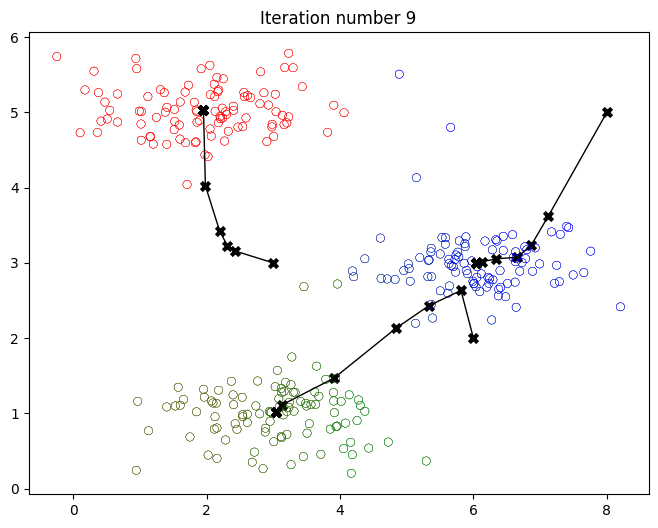

In [69]:
# Load an example dataset
X = load_data()

# Set initial centroids
initial_centroids = np.array([[3,3],[6,2],[8,5]])

# Number of iterations
max_iters = 10

# Run K-Means
centroids, idx = run_kMeans(X, initial_centroids, max_iters, plot_progress=True)

## Random initialization of centroids
* The code first randomly shuffles the indices of the examples (using np.random.permutation()).
* Then, it selects the first 𝐾 examples based on the random permutation of the indices.
* This allows the examples to be selected at random without the risk of selecting the same example twice.

In [70]:
def kMeans_init_centroids(X, K):
    """
    This function initializes K centroids that are to be 
    used in K-Means on the dataset X
    
    Args:
        X (ndarray): Data points 
        K (int):     number of centroids/clusters
    
    Returns:
        centroids (ndarray): Initialized centroids
    """
    
    # Randomly reorder the indices of examples
    randidx = np.random.permutation(X.shape[0])
    
    # Take the first K examples as centroids
    centroids = X[randidx[:K]]
    
    return centroids

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


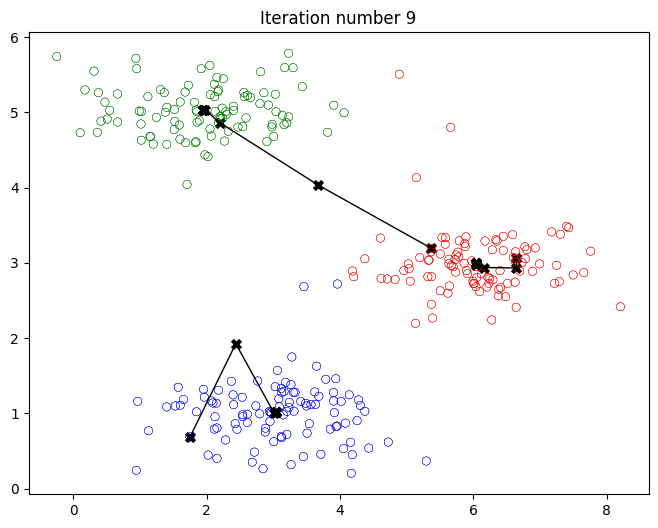

In [74]:
# Run this cell repeatedly to see different outcomes.

# Set number of centroids and max number of iterations
K = 3
max_iters = 10

# Set initial centroids by picking random examples from the dataset
initial_centroids = kMeans_init_centroids(X, K)

# Run K-Means
centroids, idx = run_kMeans(X, initial_centroids, max_iters, plot_progress=True)

## Image compression with k-means algorithm

* In a straightforward 24-bit color representation of an image 2, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often refered to as the RGB encoding.
* Our image contains thousands of colors (richer than 24-bit). We will reduce the number of colors to 16 colors. By making this reduction, it is possible to compress the photo.
* We only need to store the RGB values of the 16 selected colors, and for each pixel in the image you now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).
* Use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space.
* Then use the 16 colors to replace the pixels in the original image.
* The provided photo used in this exercise belongs to Frank Wouters and is used with his permission.

### Load and shape image data

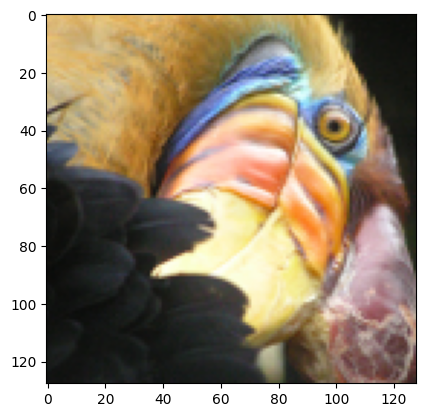

In [78]:
# Load an image of a bird
original_img = plt.imread('data/bird_small.png')

# Visualize the image
plt.imshow(original_img)

In [79]:
print("Shape of original_img is:", original_img.shape)

Shape of original_img is: (128, 128, 3)


* We will create a three-dimensional matrix of the original image where:
    * the first two indices identify a pixel position
    * the third index represents red, green, or blue
    * For example, `original_img[50, 33, 2]` gives the blue intensity of the pixel at row 50 and column 33.
* Then we normalize the data so that all values are between 0 and 1.

In [81]:
# Divide by 255 so that all values are in the range 0 - 1 (not needed for PNG files)
# original_img = original_img / 255

# Reshape the image into an m x 3 matrix where m = number of pixels
# (in this case m = 128 x 128 = 16384)
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X_img that we will use K-Means on.

X_img = np.reshape(original_img, (original_img.shape[0] * original_img.shape[1], 3))
print(X_img)

[[0.85882354 0.7058824  0.40392157]
 [0.9019608  0.7254902  0.45490196]
 [0.8862745  0.7294118  0.43137255]
 ...
 [0.25490198 0.16862746 0.15294118]
 [0.22745098 0.14509805 0.14901961]
 [0.20392157 0.15294118 0.13333334]]


### Run k-means on the treated image data

In [82]:
# Run your K-Means algorithm on this data
# You should try different values of K and max_iters here
K = 16
max_iters = 10

# Using the function you have implemented above. 
initial_centroids = kMeans_init_centroids(X_img, K)

# Run K-Means - this can take a couple of minutes depending on K and max_iters
centroids, idx = run_kMeans(X_img, initial_centroids, max_iters)

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


<Figure size 800x600 with 0 Axes>

In [83]:
print("Shape of idx:", idx.shape)
print("Closest centroid for the first five elements:", idx[:5])

Shape of idx: (16384,)
Closest centroid for the first five elements: [6 6 6 6 6]


AttributeError: 'Axes3D' object has no attribute 'w_yaxis'

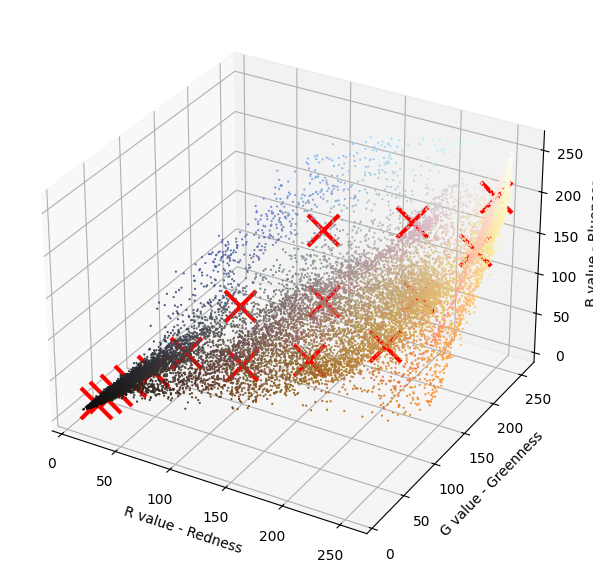

In [84]:
# Plot the colors of the image and mark the centroids
plot_kMeans_RGB(X_img, centroids, idx, K)

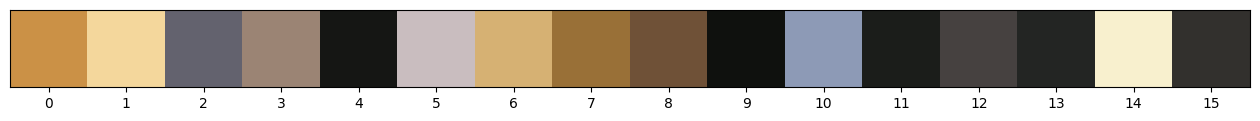

In [85]:
# Visualize the 16 colors selected
show_centroid_colors(centroids)

### Compress the image

After finding the top 𝐾=16 colors to represent the image, we can now assign each pixel position to its closest centroid using the find_closest_centroids function.

* This represents the original image using the centroid assignments of each pixel.
* We significantly reduced the number of bits that are required to describe the image.
    * The original image required 24 bits (i.e. 8 bits x 3 channels in RGB encoding) for each one of the  128×128 pixel locations. So total size: 128 × 128 × 24 = 393_216 bits.
    * The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. So total size: (16 × 24) + (128 × 128 × 4) = 65_920 bits.
    * This corresponds to compressing the original image by about a factor of 6.

In [86]:
# Find the closest centroid of each pixel
idx = find_closest_centroids(X_img, centroids)

# Replace each pixel with the color of the closest centroid
X_recovered = centroids[idx, :] 

# Reshape image into proper dimensions
X_recovered = np.reshape(X_recovered, original_img.shape) 

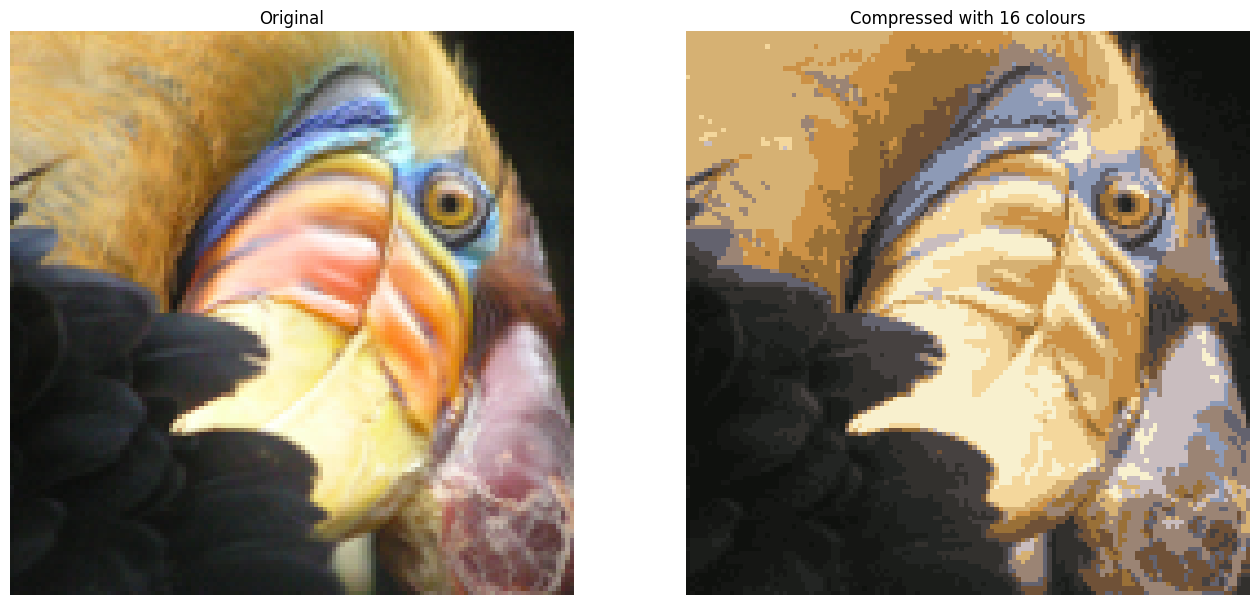

In [87]:
# Display original image
fig, ax = plt.subplots(1,2, figsize=(16,16))
plt.axis('off')

ax[0].imshow(original_img)
ax[0].set_title('Original')
ax[0].set_axis_off()


# Display compressed image
ax[1].imshow(X_recovered)
ax[1].set_title('Compressed with %d colours'%K)
ax[1].set_axis_off()